# Simplified Self Attention for Sentiment Analysis on IMDb Dataset
## Name: Rafael Gonçalves

## Imports

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
import sklearn
import torch
from torch import nn
from tqdm import notebook as tqdm
import torchtext
from torchtext.vocab import GloVe
from multiprocessing import cpu_count
from google.colab import drive
import os
from sklearn.model_selection import RandomizedSearchCV

In [2]:
! pip install skorch
import skorch

     |████████████████████████████████| 112kB 4.8MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Helper functions

In [0]:
def reproducible(seed=0):
  """Make code in reproducible using a seed for pseudorandomicity."""
  seed = 0
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  return seed

In [0]:
def use_cuda():
  """Use GPU acceleration if possible."""
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return(dev)

In [0]:
def mpl_style(style='ggplot', figsize=(10, 7.5)):
  matplotlib.style.use(style)
  plt.rcParams['figure.figsize'] = figsize

In [0]:
def config():
  """Basic notebook configuration."""
  global device, nproc, base_dir

  # Reproducibility
  if REPRODUCIBLE:
    seed = reproducible()
    print(f'Reproducible code (seed = {seed})')

  # GPU acceleration
  if USE_CUDA:
    dev = use_cuda()
  else:
    dev = 'cpu'
  device = torch.device(dev) 
  print(f'Using device: {device}')

  # CPU cores
  nproc = cpu_count()
  print(f'Using cpu with {nproc} cores')

  # Plot style
  mpl_style()

  # GDrive
  if MOUNT_DRIVE:
    path = '/content/drive'
    drive.mount(path)
    base_dir = os.path.join('/content/drive/My Drive/', 'Colab Notebooks/IA376/')
    print(f'Basedir in {base_dir}')

## Config

In [7]:
REPRODUCIBLE = False # Could not make skorch deterministic
USE_CUDA = True
MOUNT_DRIVE = True

config()

Using device: cuda:0
Using cpu with 4 cores
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Basedir in /content/drive/My Drive/Colab Notebooks/IA376/


## Simplified self attention model using for loops

Didatic example showing how self attention operations work

In [0]:
class SlowSimplifiedSelfAttention(torch.nn.Module):
    """Didatic model for showing how simplified self attention works."""
    def __init__(self, debug=0):
        super(SlowSimplifiedSelfAttention, self).__init__()
        self.softmax = torch.nn.Softmax(dim=0)
        self.debug = debug

    def forward(self, list):
        """Receives list of word vectors and return list of new
        word vectors."""
        if  torch.is_tensor(list):
            list = [list]

        new_list = []

        for x in list:
            y = torch.zeros_like(x)
            for i, query in enumerate(x):
                if self.debug:
                    print(f'query: {query}')
                scores = torch.empty(x.shape[0])
                for j, key in enumerate(x):
                    scores[j] = torch.dot(query, key).item()
                    if self.debug:
                        print(f'key: {key}, score: {scores[j]:.2f}')
                probs = self.softmax(scores)
                if self.debug:
                    print(f'probs: {probs}')

                for value, prob in zip(x, probs):
                    y[i] += value * prob
                if self.debug:
                    print(f'new word vector: {y[i]}\n')
            new_list.append(y)

        return new_list

Numeric example for testing

In [9]:
word_vec = torch.Tensor([[0.5, 1], [2, 2]])
module = SlowSimplifiedSelfAttention(debug=1)
module(word_vec)

query: tensor([0.5000, 1.0000])
key: tensor([0.5000, 1.0000]), score: 1.25
key: tensor([2., 2.]), score: 3.00
probs: tensor([0.1480, 0.8520])
new word vector: tensor([1.7779, 1.8520])

query: tensor([2., 2.])
key: tensor([0.5000, 1.0000]), score: 3.00
key: tensor([2., 2.]), score: 8.00
probs: tensor([0.0067, 0.9933])
new word vector: tensor([1.9900, 1.9933])



[tensor([[1.7779, 1.8520],
         [1.9900, 1.9933]])]

## Vectorized simplified self attention model

In [0]:
class SimplifiedSelfAttention(torch.nn.Module):
    """Self attention module."""
    def __init__(self):
        super(SimplifiedSelfAttention, self).__init__()
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """Receives 2D (or 3D if training with batches) tensor and outputs
        tensors of the same dimensions."""
        k = q = v = x # keys, queries, values = input
        scores = torch.matmul(q, k.transpose(-2,-1))
        if mask is not None: # Based on:
                             # https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/Modules.py
            scores = scores.masked_fill(mask == 0, -1e9)
        probs = self.softmax(scores)
        y = torch.matmul(probs, v)
        return y


Same numeric example for testing

In [11]:
word_vec = torch.Tensor([[0.5, 1], [2, 2]])
module = SimplifiedSelfAttention()
module(word_vec)

tensor([[1.7779, 1.8520],
        [1.9900, 1.9933]])

## Pre-trained self-attention model

In [0]:
class EmbeddingModule(nn.Module):
    def __init__(self, vocab_size, emb_dim, embeddings, pad_idx, trainable):
        """Pre-trained or not embedding look-up table layer."""
        super(EmbeddingModule, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim,
                                      _weight=embeddings, padding_idx=pad_idx)
        self.embedding.requires_grad = trainable

    def forward(self, x):
        x = self.embedding(x)
        return x

In [0]:
class SelfAttentionModel(nn.Module):
    """Model composed by an embedding look-up, an attention layer that sums up
    to one single word vector and dense layers."""
    def __init__(self,
                 hidden_layers=[],
                 out_features=2,
                 activation=nn.Tanh(),
                 self_attn_module=SimplifiedSelfAttention,
                 vocab_size=1000,
                 emb_dim=10,
                 embeddings=None,
                 embedding_module=EmbeddingModule,
                 trainable_emb=False,
                 pad_idx=0,
                 dropout=0.5
                 ):
        super(SelfAttentionModel, self).__init__()
        hidden_layers = [emb_dim, *hidden_layers]
        hidden_modules = []
        for in_feat, out_feat in zip(hidden_layers, hidden_layers[1:]):
            hidden_modules.append(nn.Linear(in_feat, out_feat))
            hidden_modules.append(activation)
            hidden_modules.append(nn.Dropout(dropout))
        self.pad_idx=pad_idx
        self.embedding = embedding_module(vocab_size, emb_dim, embeddings,
                                          pad_idx, trainable_emb)
        self.attention=self_attn_module()
        self.dense = nn.Sequential(*hidden_modules)
        self.out_layer = nn.Linear(hidden_layers[-1], out_features)

    def create_mask(self, tensor, idx):
        mask = torch.ones_like(tensor)
        mask[tensor == idx] = 0
        return mask.unsqueeze(-2) # Broadcast new axis

    def forward(self, x):
        mask = self.create_mask(x, self.pad_idx)
        x = self.embedding(x)
        x = self.attention(x, mask)
        x = torch.sum(x, dim=-2)
        x = self.dense(x)
        x = self.out_layer(x)
        return x

In [14]:
SelfAttentionModel()

SelfAttentionModel(
  (embedding): EmbeddingModule(
    (embedding): Embedding(1000, 10, padding_idx=0)
  )
  (attention): SimplifiedSelfAttention(
    (softmax): Softmax(dim=-1)
  )
  (dense): Sequential()
  (out_layer): Linear(in_features=10, out_features=2, bias=True)
)

## Download dataset

In [15]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2020-04-08 21:50:19--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K  1.63MB/s    in 0.3s    

2020-04-08 21:50:19 (1.63 MB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



In [16]:
df = pd.read_csv('imdb_sample/texts.csv')
df.head()

label                                               text  is_valid
0  negative  Un-bleeping-believable! Meg Ryan doesn't even ...     False
1  positive  This is a extremely well-made film. The acting...     False
2  negative  Every once in a long while a movie will come a...     False
3  positive  Name just says it all. I watched this movie wi...     False
4  negative  This movie succeeds at being one of the most u...     False

In [17]:
df_train = df[df['is_valid'] == False]
df_val = df[df['is_valid'] == True]
print("Train data:", df_train.shape)
print("Validation data:", df_val.shape)

Train data: (800, 3)
Validation data: (200, 3)


In [18]:
df_train

label                                               text  is_valid
0    negative  Un-bleeping-believable! Meg Ryan doesn't even ...     False
1    positive  This is a extremely well-made film. The acting...     False
2    negative  Every once in a long while a movie will come a...     False
3    positive  Name just says it all. I watched this movie wi...     False
4    negative  This movie succeeds at being one of the most u...     False
..        ...                                                ...       ...
795  negative  The ghost of the Vietnam war has haunted the A...     False
796  negative  Thin story concerns two small town brothers an...     False
797  positive  Not everything is said in this excellent first...     False
798  negative  This is just horrible, really horrible trash. ...     False
799  negative  I don't often go out of my way to write commen...     False

[800 rows x 3 columns]

## Download pretrained word vectors (GloVe)

In [0]:
dataset_path = os.path.join(base_dir, 'data')
glove_dir = os.path.join(dataset_path, 'glove_dir')

In [0]:
glove_vectors = GloVe(name='6B', dim=300, cache=glove_dir)

In [21]:
print(glove_vectors.vectors.shape)
print('Primeiras 20 palavras e seus índices:', list(glove_vectors.stoi.items())[:20])

torch.Size([400000, 300])
Primeiras 20 palavras e seus índices: [('the', 0), (',', 1), ('.', 2), ('of', 3), ('to', 4), ('and', 5), ('in', 6), ('a', 7), ('"', 8), ("'s", 9), ('for', 10), ('-', 11), ('that', 12), ('on', 13), ('is', 14), ('was', 15), ('said', 16), ('with', 17), ('he', 18), ('as', 19)]


In [22]:
vocab = glove_vectors.stoi
vocab['<pad>'] = len(vocab)
vocab_rev = glove_vectors.itos
vocab_rev.append('<pad>')
vectors = glove_vectors.vectors
vectors = torch.cat((vectors, torch.zeros_like(vectors[0].view(1,-1))))
len(vocab.items()), vectors.shape

(400001, torch.Size([400001, 300]))

## Create dataloaders

In [0]:
corpus_train = df_train['text']
corpus_test = df_val['text']

y_train = [1 if (e == 'positive') else 0 for e in df_train['label'].to_numpy()]
y_test = [1 if (e == 'positive') else 0 for e in df_val['label'].to_numpy()]

In [0]:
x_train = [[vocab[e] for e in sample.split() if e in vocab.keys()] for sample in corpus_train]
x_test = [[vocab[e] for e in sample.split() if e in vocab.keys()] for sample in corpus_test]

In [25]:
train_len = [len(e) for e in x_train]
np.mean(train_len), np.median(train_len), np.max(train_len), sorted(train_len)[80*len(train_len)//100]

(183.72125, 140.0, 902, 273)

In [0]:
def lists_to_tensor(list, vocab, max_tokens=275):
    pad = vocab['<pad>']
    len_l = [len(s) for s in list]
    max_len = np.min((np.max(len_l), max_tokens))
    out = []
    for sample, leng in zip(list, len_l):
        if leng < max_len:
            sample = sample.extend([pad]*(max_len-leng))
        if leng > max_len:
            sample = sample[:max_len]
        out.append(sample)
    return torch.Tensor(out).type(torch.long)


In [30]:
x_tr_t = lists_to_tensor(x_train, vocab)
x_tst_t = lists_to_tensor(x_test, vocab)
y_tr_t = torch.Tensor(y_train).type(torch.long)
y_tst_t = torch.Tensor(y_test).type(torch.long)
print(x_tr_t.size(), x_tst_t.size(), y_tr_t.size(), y_tst_t.size())

torch.Size([800, 275]) torch.Size([200, 275]) torch.Size([800]) torch.Size([200])


## Training with Skorch

Testing with model with just output fc layer

In [0]:
model = skorch.NeuralNetClassifier(
    SelfAttentionModel,
    max_epochs=10,
    lr=0.01,
    device=device,
    batch_size=50,
    train_split=skorch.dataset.CVSplit(3),
    criterion=torch.nn.CrossEntropyLoss,
    module__vocab_size=vectors.size(0),
    module__emb_dim=vectors.size(1),
    module__embeddings=vectors,
    module__pad_idx=len(vocab)-1,
    iterator_train__shuffle=True,
    iterator_train__num_workers=nproc,
    iterator_valid__num_workers=nproc,
    iterator_train__pin_memory=True,
    iterator_valid__pin_memory=True,
    callbacks=[skorch.callbacks.EarlyStopping(patience=3)]
)

In [32]:
model.fit(x_tr_t, y_tr_t)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1     1682.6608       0.4831      810.2053  0.7343
      2      931.1678       0.4831      378.8124  0.4719
      3      614.7132       0.4831      201.6951  0.4710
      4      382.4069       0.5056      114.7872  0.4612
      5      123.9826       0.5581      141.3690  0.4649
      6       64.6026       0.7116       23.6959  0.4781
      7       50.3611       0.7865       11.8396  0.4548
      8       22.2145       0.6816       23.5935  0.4637
      9       15.6906       0.7940       10.4481  0.4641
     10       11.9107       0.6554       20.8492  0.4598


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SelfAttentionModel(
    (embedding): EmbeddingModule(
      (embedding): Embedding(400001, 300, padding_idx=400000)
    )
    (attention): SimplifiedSelfAttention(
      (softmax): Softmax(dim=-1)
    )
    (dense): Sequential()
    (out_layer): Linear(in_features=300, out_features=2, bias=True)
  ),
)

Testing with model with one hidden fc layer

In [0]:
model_1= skorch.NeuralNetClassifier(
    SelfAttentionModel,
    max_epochs=10,
    lr=0.03,
    batch_size=20,
    train_split=skorch.dataset.CVSplit(3),
    criterion=torch.nn.CrossEntropyLoss,
    module__vocab_size=vectors.size(0),
    module__emb_dim=vectors.size(1),
    module__embeddings=vectors,
    module__pad_idx=len(vocab)-1,
    module__hidden_layers=[50],
    iterator_train__shuffle=True,
    iterator_train__num_workers=nproc,
    iterator_valid__num_workers=nproc,
    iterator_train__pin_memory=True,
    iterator_valid__pin_memory=True,
    device=device,
    callbacks=[skorch.callbacks.EarlyStopping(patience=3)]
)

In [34]:
model_1.fit(x_tr_t, y_tr_t)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7909       0.5169        0.6962  0.6369
      2        0.7722       0.5169        0.6926  0.6201
      3        0.7442       0.4831        0.7513  0.6106
      4        0.7292       0.4831        0.7113  0.6241
Stopping since valid_loss has not improved in the last 3 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SelfAttentionModel(
    (embedding): EmbeddingModule(
      (embedding): Embedding(400001, 300, padding_idx=400000)
    )
    (attention): SimplifiedSelfAttention(
      (softmax): Softmax(dim=-1)
    )
    (dense): Sequential(
      (0): Linear(in_features=300, out_features=50, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.5, inplace=False)
    )
    (out_layer): Linear(in_features=50, out_features=2, bias=True)
  ),
)

Fine tunning parameters with RandomizedSearchCV

In [0]:
model_2 = skorch.NeuralNetClassifier(
    SelfAttentionModel,
    max_epochs=50,
    batch_size=50,
    criterion=torch.nn.CrossEntropyLoss,
    module__vocab_size=vectors.size(0),
    module__emb_dim=vectors.size(1),
    module__embeddings=vectors,
    module__pad_idx=len(vocab)-1,
    iterator_train__shuffle=True,
    iterator_train__pin_memory=True,
    iterator_valid__pin_memory=True,
    device=device,    
    verbose=0,
    callbacks=[skorch.callbacks.EarlyStopping(patience=5)]
)

In [0]:
from sklearn.model_selection import GridSearchCV
lr = (10**np.random.uniform(-3.5,-1.5, 100)).tolist()
params = {
    'optimizer__lr': [0.001, 0.005, 0.01, 0.05, 0.1],
    'optimizer__momentum': [0, 0.9],
    'module__dropout': [0, 0.2, 0.5],
    'module__hidden_layers': [[], [30], [100], [30, 30]]
}

gs = GridSearchCV(model_2, params, refit=True, cv=3, scoring='accuracy', n_jobs=1, verbose=1)

In [37]:
gs.fit(x_tr_t, y_tr_t)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 11.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.SelfAttentionModel'>,
  module__emb_dim=300,
  module__embeddings=tensor([[ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
          [-0.2554, -0.2572,  0.1317,  ..., -0.2329, -0.1223,  0.3550],
          [-0.1256,  0.0136,  0.1031,  ..., -0.3422, -0.0224,  0.1368],...
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
  module__pad_idx=400000,
  module__vocab_size=400001,
),
             iid='deprecated', n_jobs=1,
             param_grid={'module__dropout': [0, 0.2, 0.5],
                         'module__hidden_layers': [[], [30], [100], [30, 30]],
                         'optimizer__lr': [0.001, 0.005, 0.01, 0.05, 0.1],
                         'optimizer__momentum': [0, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [38]:
print(gs.best_score_, gs.best_params_)

0.743746069293083 {'module__dropout': 0, 'module__hidden_layers': [], 'optimizer__lr': 0.005, 'optimizer__momentum': 0.9}


In [0]:
epochs = [i for i, _ in enumerate(gs.best_estimator_.history)]
train_loss = gs.best_estimator_.history[:, 'train_loss']
valid_loss = gs.best_estimator_.history[:, 'valid_loss']
accuracy = gs.best_estimator_.history[:, 'valid_acc']

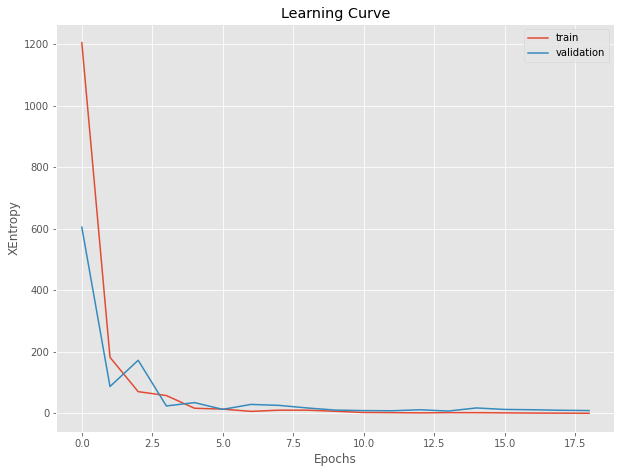

In [40]:
plt.plot(epochs, train_loss)
plt.plot(epochs, valid_loss)
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('XEntropy')
plt.legend(['train', 'validation'])
plt.show()

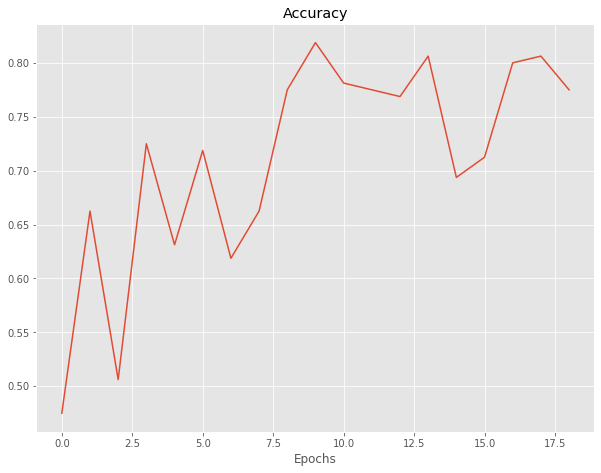

In [41]:
plt.plot(epochs, accuracy)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [42]:
model_3 = gs.best_estimator_
model_3.initialize()

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SelfAttentionModel(
    (embedding): EmbeddingModule(
      (embedding): Embedding(400001, 300, padding_idx=400000)
    )
    (attention): SimplifiedSelfAttention(
      (softmax): Softmax(dim=-1)
    )
    (dense): Sequential()
    (out_layer): Linear(in_features=300, out_features=2, bias=True)
  ),
)

In [0]:
model_3.max_epochs = 100
model_3.callbacks__patience = 10

In [44]:
model_3.fit(x_tr_t, y_tr_t)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SelfAttentionModel(
    (embedding): EmbeddingModule(
      (embedding): Embedding(400001, 300, padding_idx=400000)
    )
    (attention): SimplifiedSelfAttention(
      (softmax): Softmax(dim=-1)
    )
    (dense): Sequential()
    (out_layer): Linear(in_features=300, out_features=2, bias=True)
  ),
)

In [0]:
epochs = [i for i, _ in enumerate(model_3.history)]
train_loss = model_3.history[:, 'train_loss']
valid_loss = model_3.history[:, 'valid_loss']
accuracy = model_3.history[:, 'valid_acc']

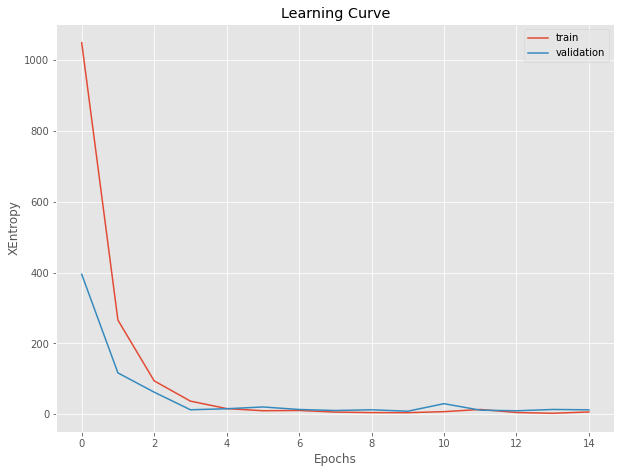

In [46]:
plt.plot(epochs, train_loss)
plt.plot(epochs, valid_loss)
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('XEntropy')
plt.legend(['train', 'validation'])
plt.show()

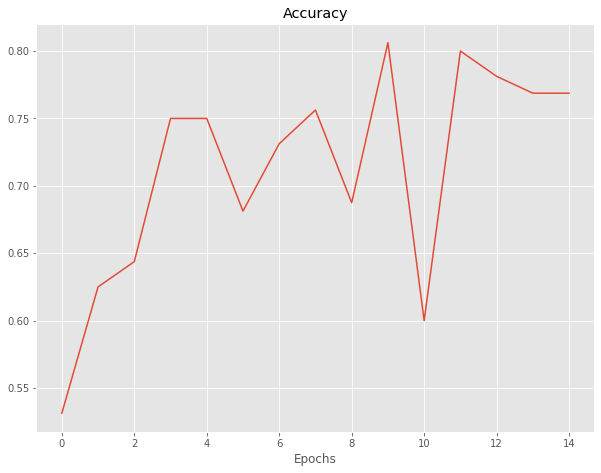

In [47]:
plt.plot(epochs, accuracy)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.show()

## Evaluating in unseen test data

In [48]:
y = torch.Tensor(model_3.predict(x_tst_t)).type(torch.long).flatten(); y.size()

torch.Size([200])

In [49]:
correct = (y==y_tst_t).sum(); correct

tensor(150)

In [50]:
accuracy = correct/float(len(y_tst_t));accuracy

tensor(0.7500)

# End of notebook